In [120]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy

from shap import Cohorts, Explanation
from shap.plots._labels import labels
from shap.plots._utils import (
    convert_ordering,
    dendrogram_coords,
    get_sort_order,
    merge_nodes,
    sort_inds,
)
from shap.plots.colors import blue_rgb, red_rgb
from shap.utils import format_value, ordinal_str
from shap.utils._exceptions import DimensionError


def bar(
    shap_values,
    max_display=10,
    order=Explanation.abs,
    clustering=None,
    clustering_cutoff=0.5,
    show_data="auto",
    ax=None,
    show=True,
):
    """Create a bar plot of a set of SHAP values."""

    # convert Explanation objects to dictionaries
    if isinstance(shap_values, Explanation):
        cohorts = {"": shap_values}
    elif isinstance(shap_values, Cohorts):
        cohorts = shap_values.cohorts
    elif isinstance(shap_values, dict):
        cohorts = shap_values
    else:
        raise TypeError(
            "The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!"
        )

    # unpack our list of Explanation objects we need to plot
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i, exp in enumerate(cohort_exps):
        if not isinstance(exp, Explanation):
            raise TypeError(
                "The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!"
            )

        if len(exp.shape) == 2:
            # collapse the Explanation arrays to be of shape (#features,)
            cohort_exps[i] = exp.abs.mean(0)
        if cohort_exps[i].shape != cohort_exps[0].shape:
            raise DimensionError(
                "When passing several Explanation objects, they must all have the same number of feature columns!"
            )

    # unpack the Explanation object
    features = (
        cohort_exps[0].display_data
        if cohort_exps[0].display_data is not None
        else cohort_exps[0].data
    )
    feature_names = cohort_exps[0].feature_names
    if clustering is None:
        partition_tree = getattr(cohort_exps[0], "clustering", None)
    elif clustering is False:
        partition_tree = None
    else:
        partition_tree = clustering

    if partition_tree is not None:
        if len(partition_tree.shape) != 2 or partition_tree.shape[1] != 4:
            raise TypeError(
                "The clustering provided by the Explanation object does not seem to be a partition tree, which is all shap.plots.bar supports."
            )

    op_history = cohort_exps[0].op_history
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])

    if len(values[0]) == 0:
        raise ValueError(
            "The passed Explanation is empty, so there is nothing to plot."
        )

    if show_data == "auto":
        transforms = [t for t in op_history if t.get("name") != "__getitem__"]
        show_data = len(transforms) == 0

    if issubclass(type(feature_names), str):
        feature_names = [
            ordinal_str(i) + " " + feature_names for i in range(len(values[0]))
        ]

    xlabel = "SHAP value"
    for op in op_history:
        if op["name"] == "abs":
            xlabel = "|" + xlabel + "|"
        elif op["name"] == "__getitem__":
            pass
        else:
            xlabel = str(op["name"]) + "(" + xlabel + ")"

    cohort_sizes = []
    for exp in cohort_exps:
        for op in exp.op_history:
            if op.get("collapsed_instances", False):
                cohort_sizes.append(op["prev_shape"][0])
                break

    if isinstance(features, pd.Series):
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    if feature_names is None:
        feature_names = np.array(
            [labels["FEATURE"] % str(i) for i in range(len(values[0]))]
        )

    if max_display is None:
        max_display = len(feature_names)
    num_features = min(max_display, len(values[0]))
    max_display = min(max_display, num_features)

    orig_inds = [[i] for i in range(len(values[0]))]
    orig_values = values.copy()

    while True:
        feature_order = np.argsort(
            np.mean(
                [
                    np.argsort(convert_ordering(order, Explanation(values[i])))
                    for i in range(values.shape[0])
                ],
                0,
            )
        )
        if partition_tree is not None:
            clust_order = sort_inds(partition_tree, np.abs(values).mean(0))
            dist = scipy.spatial.distance.squareform(
                scipy.cluster.hierarchy.cophenet(partition_tree)
            )
            feature_order = get_sort_order(
                dist, clust_order, clustering_cutoff, feature_order
            )

            if (
                max_display < len(feature_order)
                and dist[feature_order[max_display - 1], feature_order[max_display - 2]]
                <= clustering_cutoff
            ):
                partition_tree, ind1, ind2 = merge_nodes(
                    np.abs(values).mean(0), partition_tree
                )
                for i in range(len(values)):
                    values[:, ind1] += values[:, ind2]
                    values = np.delete(values, ind2, 1)
                    orig_inds[ind1] += orig_inds[ind2]
                    del orig_inds[ind2]
            else:
                break
        else:
            break

    combined_values = []
    combined_feature_names = []
    merged_features = np.zeros(len(feature_names), dtype=bool)
    for i in range(len(values[0])):
        if not merged_features[i]:
            combined_value = values[:, i].copy()
            feature_name = feature_names[i]
            if partition_tree is not None:
                for j in range(i + 1, len(values[0])):
                    if dist[feature_order[i], feature_order[j]] <= clustering_cutoff:
                        combined_value += values[:, j]
                        feature_name += " + " + feature_names[j]
                        merged_features[j] = True
            combined_values.append(combined_value)
            combined_feature_names.append(feature_name)
    combined_values = np.array(combined_values).T

    if max_display is None:
        max_display = len(combined_feature_names)
    num_features = min(max_display, len(combined_feature_names))
    max_display = min(max_display, num_features)

    feature_order = np.argsort(
        np.mean(
            [
                np.argsort(convert_ordering(order, Explanation(combined_values[i])))
                for i in range(combined_values.shape[0])
            ],
            0,
        )
    )
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)

    yticklabels = []
    for i in feature_inds:
        if features is not None and show_data:
            yticklabels.append(
                format_value(features[i], "%0.03f") + " = " + combined_feature_names[i]
            )
        else:
            yticklabels.append(combined_feature_names[i])

    if ax is None:
        ax = pl.gca()
        fig = pl.gcf()
        row_height = 0.5
        fig.set_size_inches(
            8, num_features * row_height * np.sqrt(len(combined_values)) + 1.5
        )

    negative_values_present = (
        np.sum(combined_values[:, feature_order[:num_features]] < 0) > 0
    )
    if negative_values_present:
        ax.axvline(0, 0, 1, color="#000000", linestyle="-", linewidth=1, zorder=1)

    patterns = (None, "\\\\", "++", "xx", "////", "*", "o", "O", ".", "-")
    total_width = 0.7
    bar_width = total_width / len(combined_values)
    for i in range(len(combined_values)):
        ypos_offset = -((i - len(combined_values) / 2) * bar_width + bar_width / 2)
        ax.barh(
            y_pos + ypos_offset,
            combined_values[i, feature_inds],
            bar_width,
            align="center",
            color=[
                blue_rgb if combined_values[i, feature_inds[j]] <= 0 else red_rgb
                for j in range(len(y_pos))
            ],
            hatch=patterns[i],
            edgecolor=(1, 1, 1, 0.8),
            label=f"{cohort_labels[i]} [{cohort_sizes[i] if i < len(cohort_sizes) else None}]",
        )

    ax.set_yticks(
        list(y_pos) + list(y_pos + 1e-8),
        yticklabels + [t.split("=")[-1] for t in yticklabels],
        fontsize=13,
    )

    xlen = ax.get_xlim()[1] - ax.get_xlim()[0]
    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    width = bbox.width
    bbox_to_xscale = xlen / width

    for i in range(len(combined_values)):
        ypos_offset = -((i - len(combined_values) / 2) * bar_width + bar_width / 2)
        for j in range(len(y_pos)):
            ind = feature_order[j]
            if combined_values[i, ind] < 0:
                ax.text(
                    combined_values[i, ind] - (5 / 72) * bbox_to_xscale,
                    y_pos[j] + ypos_offset,
                    format_value(combined_values[i, ind], "%+0.02f"),
                    horizontalalignment="right",
                    verticalalignment="center",
                    color=blue_rgb,
                    fontsize=12,
                )
            else:
                ax.text(
                    combined_values[i, ind] + (5 / 72) * bbox_to_xscale,
                    y_pos[j] + ypos_offset,
                    format_value(combined_values[i, ind], "%+0.02f"),
                    horizontalalignment="left",
                    verticalalignment="center",
                    color=red_rgb,
                    fontsize=12,
                )

    for i in range(num_features):
        ax.axhline(i + 1, color="#888888", lw=0.5, dashes=(1, 5), zorder=-1)

    if features is not None:
        features = list(features)

        for i in range(len(features)):
            try:
                if round(features[i]) == features[i]:
                    features[i] = int(features[i])
            except Exception:
                pass

    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("none")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if negative_values_present:
        ax.spines["left"].set_visible(False)
    ax.tick_params("x", labelsize=11)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    x_buffer = (xmax - xmin) * 0.05

    if negative_values_present:
        ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
    else:
        ax.set_xlim(xmin, xmax + x_buffer)

    ax.set_xlabel(xlabel, fontsize=13)

    if len(combined_values) > 1:
        ax.legend(fontsize=12)

    tick_labels = ax.yaxis.get_majorticklabels()
    for i in range(num_features):
        tick_labels[i].set_color("#999999")

    if partition_tree is not None:
        feature_pos = np.argsort(feature_order[:max_display])
        ylines, xlines = dendrogram_coords(
            feature_pos, partition_tree[: len(feature_pos) - 1]
        )

        xmin, xmax = ax.get_xlim()
        xlines_min, xlines_max = np.min(xlines), np.max(xlines)
        ct_line_pos = (clustering_cutoff / (xlines_max - xlines_min)) * 0.1 * (
            xmax - xmin
        ) + xmax
        ax.text(
            ct_line_pos + 0.005 * (xmax - xmin),
            (ymax - ymin) / 2,
            "Clustering cutoff = " + format_value(clustering_cutoff, "%0.02f"),
            horizontalalignment="left",
            verticalalignment="center",
            color="#999999",
            fontsize=12,
            rotation=-90,
        )
        line = ax.axvline(ct_line_pos, color="#dddddd", dashes=(1, 1))
        line.set_clip_on(False)

        for xline, yline in zip(xlines, ylines):
            xv = np.array(xline) / (xlines_max - xlines_min)
            if np.array(xline).max() <= clustering_cutoff:
                if yline.max() < max_display:
                    lines = ax.plot(
                        xv * 0.1 * (xmax - xmin) + xmax,
                        max_display - np.array(yline),
                        color="#999999",
                    )
                    for line in lines:
                        line.set_clip_on(False)

    if show:
        pl.show()
    else:
        return ax

In [122]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor

import shap

seed = 2023
np.random.seed(seed)

In [124]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

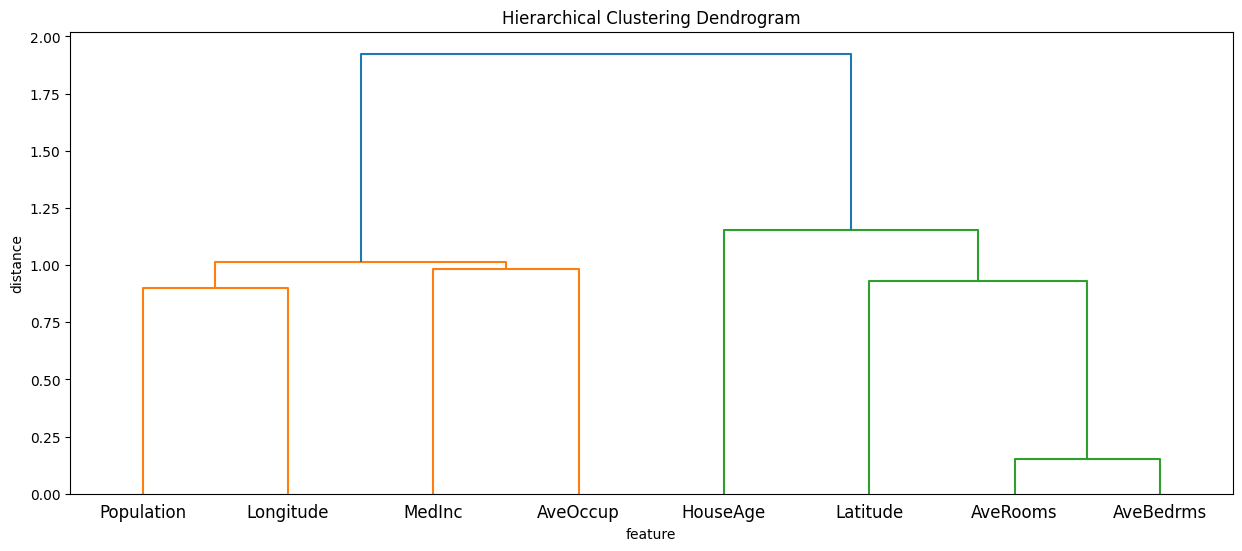

In [126]:
partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

In [128]:
# build a masker from partition tree
masker = shap.maskers.Partition(X, clustering=partition_tree)

# build explainer objects
# raw_explainer = PartitionExplainer2(model.predict, X)
masker_explainer = shap.PartitionExplainer(model.predict, masker)

# compute SHAP values
# raw_shap_values = raw_explainer(instance)
masker_shap_values = masker_explainer(instance)

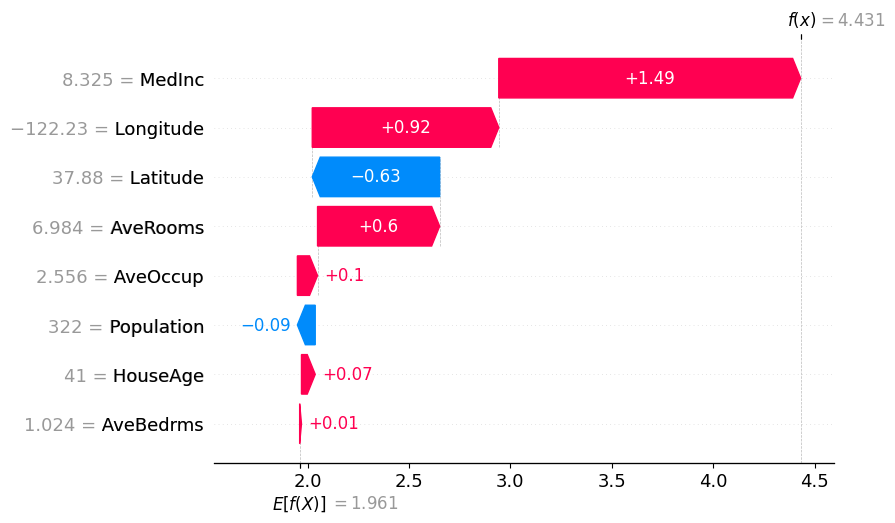

In [130]:
shap.plots.waterfall(masker_shap_values[0])

RecursionError: maximum recursion depth exceeded while calling a Python object

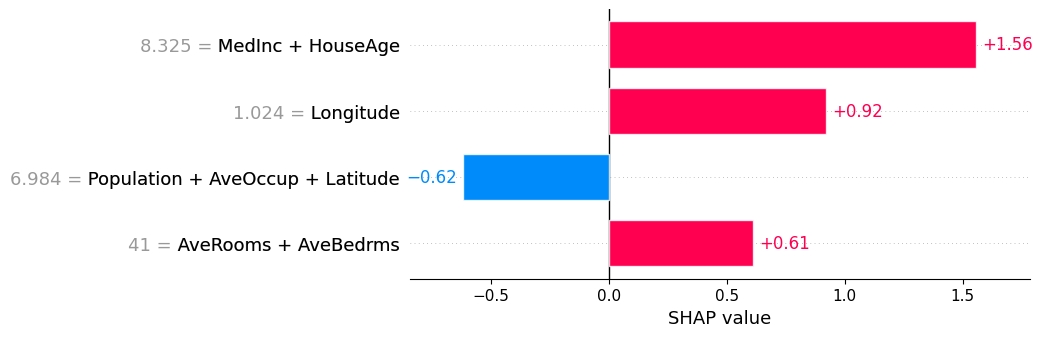

In [135]:
bar(masker_shap_values[0], clustering=partition_tree, clustering_cutoff=1)